AGV Warehouse Path Optimization Simulator

Warehouse: 30x30
Start: (2, 2), Goal: (27, 27)

Running A* Algorithm...
  ✓ Path Length: 51
  ✓ Nodes Explored: 282
  ✓ Time: 1.55 ms

Running Dijkstra Algorithm...
  ✓ Path Length: 51
  ✓ Nodes Explored: 814
  ✓ Time: 2.56 ms

Running BFS Algorithm...
  ✓ Path Length: 51
  ✓ Nodes Explored: 813
  ✓ Time: 0.87 ms

Generating visualizations...
Showing A* result...
Plot saved to astar_result.png


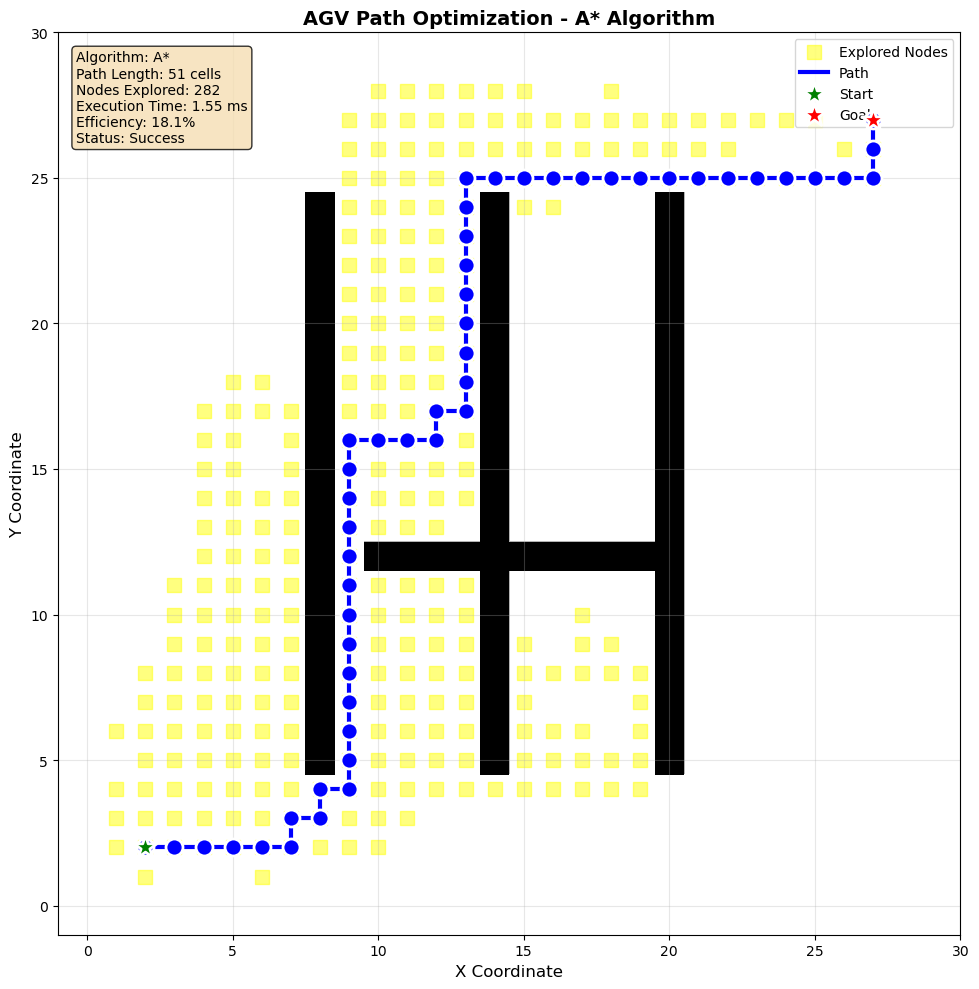

Showing algorithm comparison...
Comparison plot saved to algorithm_comparison.png


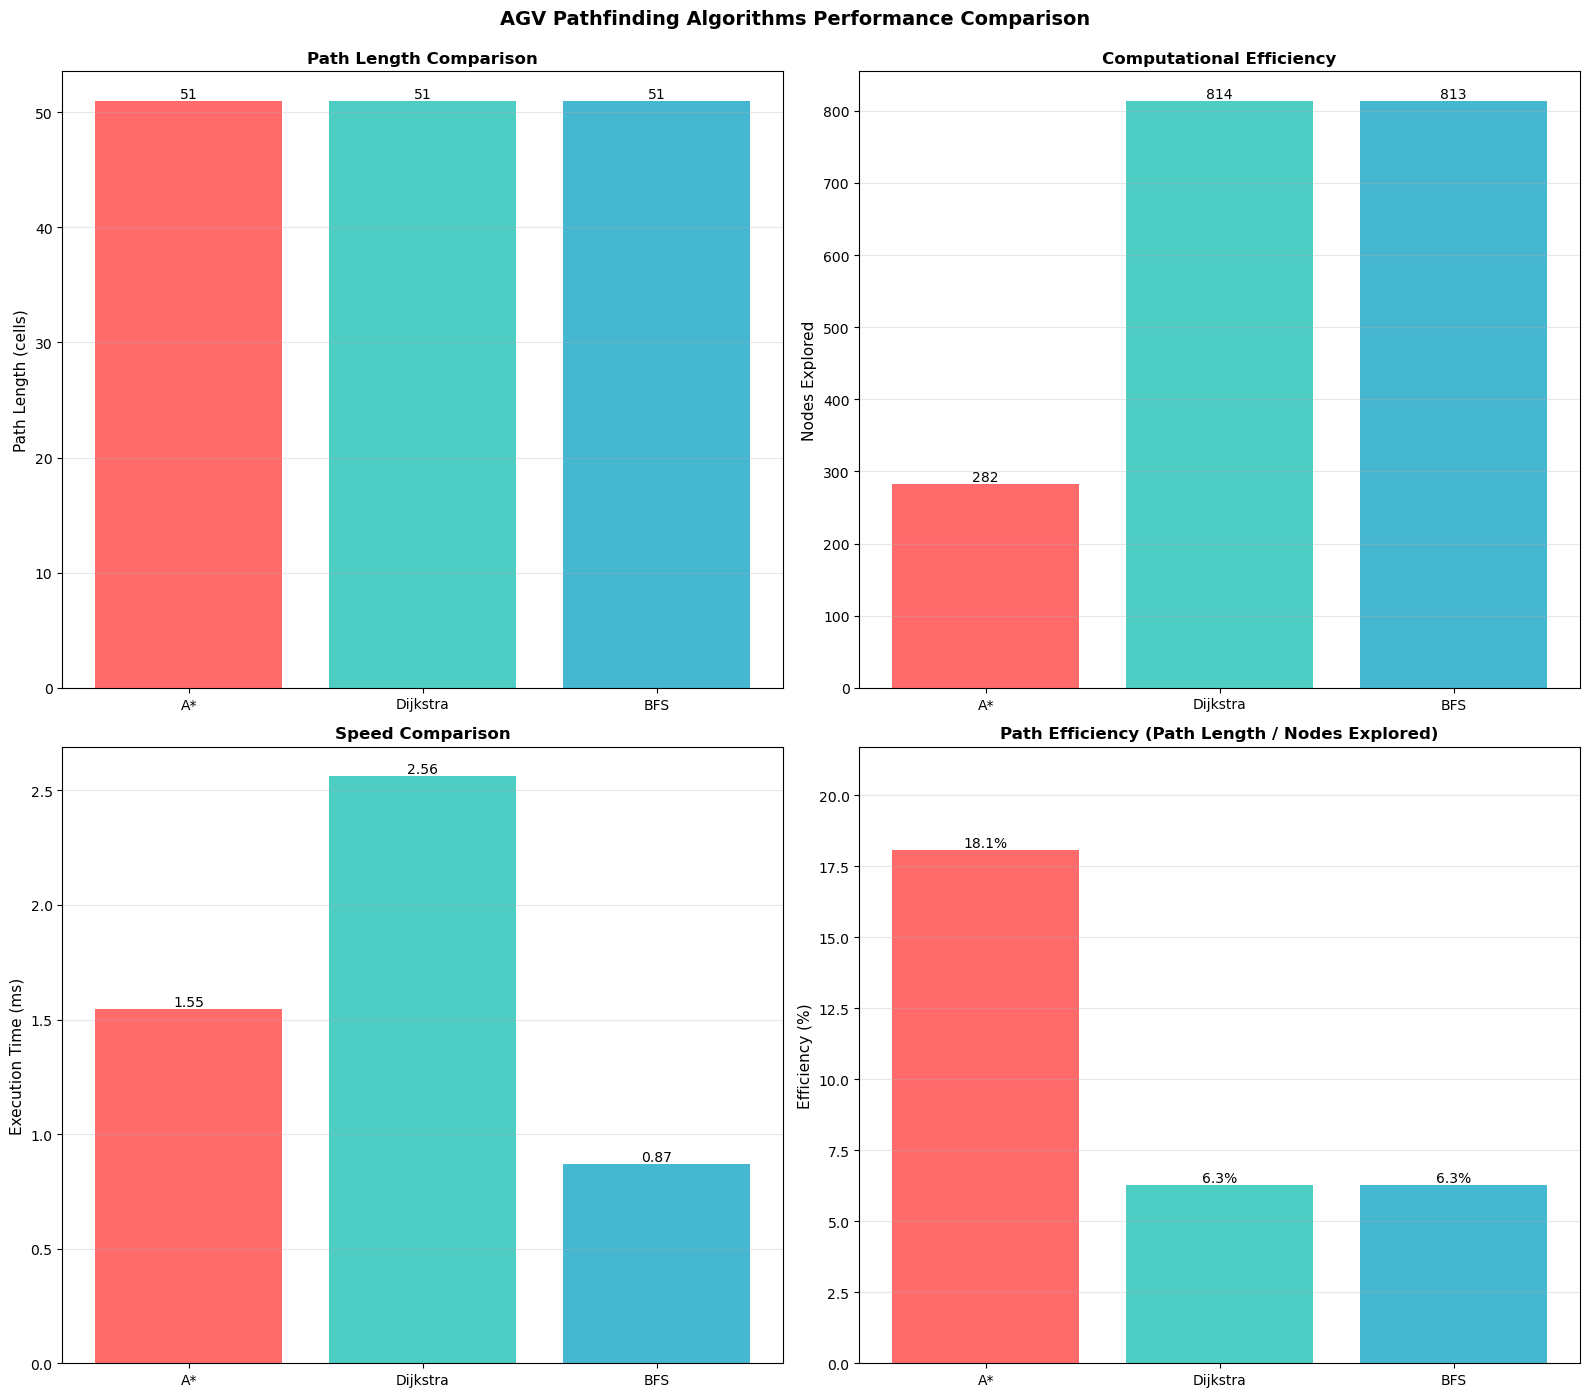

Results saved to pathfinding_results.json

Analysis Complete!

Generated files:
  - astar_result.png
  - algorithm_comparison.png
  - pathfinding_results.json


In [2]:
"""
AGV Warehouse Path Optimization Simulator
==========================================
A comprehensive implementation of pathfinding algorithms for AGV navigation.

Author: Laxman Maheshwaram
Date: January 2026
Project: AI/ML for Automated In-Plant Logistics
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from collections import deque
import heapq
import time
import json
from datetime import datetime
from typing import List, Tuple, Dict, Set, Optional
from dataclasses import dataclass, asdict


@dataclass
class Node:
    """Represents a node in the grid."""
    x: int
    y: int
    g: float = float('inf')  # Cost from start
    h: float = 0.0  # Heuristic cost to goal
    f: float = float('inf')  # Total cost
    parent: Optional['Node'] = None
    
    def __lt__(self, other):
        return self.f < other.f
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __repr__(self):
        return f"Node({self.x}, {self.y})"


class WarehouseGrid:
    """Represents a warehouse layout with obstacles."""
    
    def __init__(self, width: int = 30, height: int = 30):
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width), dtype=int)
        self.start = (2, 2)
        self.goal = (width - 3, height - 3)
        
    def add_obstacle(self, x: int, y: int):
        """Add an obstacle at position (x, y)."""
        if 0 <= x < self.width and 0 <= y < self.height:
            self.grid[y, x] = 1
    
    def remove_obstacle(self, x: int, y: int):
        """Remove an obstacle at position (x, y)."""
        if 0 <= x < self.width and 0 <= y < self.height:
            self.grid[y, x] = 0
    
    def is_obstacle(self, x: int, y: int) -> bool:
        """Check if position is an obstacle."""
        if not (0 <= x < self.width and 0 <= y < self.height):
            return True
        return self.grid[y, x] == 1
    
    def create_warehouse_layout(self, layout_type: str = "default"):
        """Create predefined warehouse layouts."""
        self.grid = np.zeros((self.height, self.width), dtype=int)
        
        if layout_type == "default":
            # Vertical racks
            for i in range(5, 25):
                self.grid[i, 8] = 1
                self.grid[i, 14] = 1
                self.grid[i, 20] = 1
            
            # Horizontal obstacles
            for j in range(10, 20):
                self.grid[12, j] = 1
        
        elif layout_type == "maze":
            # Create a maze-like structure
            for i in range(5, 25):
                if i % 4 != 0:
                    self.grid[i, 10] = 1
                    self.grid[i, 20] = 1
            for j in range(5, 25):
                if j % 4 != 0:
                    self.grid[10, j] = 1
                    self.grid[20, j] = 1
        
        elif layout_type == "open":
            # Minimal obstacles for comparison
            self.grid[15, 15] = 1
            self.grid[15, 16] = 1
            self.grid[16, 15] = 1
    
    def get_neighbors(self, x: int, y: int, allow_diagonal: bool = False) -> List[Tuple[int, int]]:
        """Get valid neighbors of a position."""
        neighbors = []
        
        # 4-directional movement
        directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]
        
        # Add diagonal movements if allowed
        if allow_diagonal:
            directions.extend([(1, -1), (1, 1), (-1, 1), (-1, -1)])
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if not self.is_obstacle(nx, ny):
                    neighbors.append((nx, ny))
        
        return neighbors


class PathfindingAlgorithms:
    """Collection of pathfinding algorithms for AGV navigation."""
    
    def __init__(self, warehouse: WarehouseGrid):
        self.warehouse = warehouse
        self.visited_nodes = []
        self.path = []
        
    @staticmethod
    def heuristic(a: Tuple[int, int], b: Tuple[int, int], metric: str = "manhattan") -> float:
        """Calculate heuristic distance between two points."""
        if metric == "manhattan":
            return abs(a[0] - b[0]) + abs(a[1] - b[1])
        elif metric == "euclidean":
            return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
        elif metric == "chebyshev":
            return max(abs(a[0] - b[0]), abs(a[1] - b[1]))
        return 0
    
    def a_star(self, start: Tuple[int, int], goal: Tuple[int, int], 
               allow_diagonal: bool = False, heuristic_type: str = "manhattan") -> Dict:
        """
        A* pathfinding algorithm.
        
        Args:
            start: Starting position (x, y)
            goal: Goal position (x, y)
            allow_diagonal: Whether to allow diagonal movement
            heuristic_type: Type of heuristic ('manhattan', 'euclidean', 'chebyshev')
        
        Returns:
            Dictionary with path, visited nodes, and metrics
        """
        start_time = time.time()
        self.visited_nodes = []
        
        # Initialize start node
        start_node = Node(start[0], start[1], g=0, 
                         h=self.heuristic(start, goal, heuristic_type))
        start_node.f = start_node.h
        
        open_set = [start_node]
        closed_set = set()
        node_map = {(start[0], start[1]): start_node}
        
        while open_set:
            current = heapq.heappop(open_set)
            
            if (current.x, current.y) == goal:
                # Reconstruct path
                path = []
                while current:
                    path.append((current.x, current.y))
                    current = current.parent
                path.reverse()
                
                return {
                    'path': path,
                    'visited': self.visited_nodes,
                    'path_length': len(path),
                    'nodes_explored': len(self.visited_nodes),
                    'execution_time': time.time() - start_time,
                    'algorithm': 'A*',
                    'success': True
                }
            
            closed_set.add((current.x, current.y))
            self.visited_nodes.append((current.x, current.y))
            
            # Explore neighbors
            for nx, ny in self.warehouse.get_neighbors(current.x, current.y, allow_diagonal):
                if (nx, ny) in closed_set:
                    continue
                
                # Calculate cost
                move_cost = 1.0 if not allow_diagonal else \
                           (1.414 if abs(nx - current.x) + abs(ny - current.y) == 2 else 1.0)
                tentative_g = current.g + move_cost
                
                if (nx, ny) not in node_map:
                    neighbor = Node(nx, ny)
                    node_map[(nx, ny)] = neighbor
                else:
                    neighbor = node_map[(nx, ny)]
                
                if tentative_g < neighbor.g:
                    neighbor.parent = current
                    neighbor.g = tentative_g
                    neighbor.h = self.heuristic((nx, ny), goal, heuristic_type)
                    neighbor.f = neighbor.g + neighbor.h
                    
                    if neighbor not in open_set:
                        heapq.heappush(open_set, neighbor)
        
        return {
            'path': [],
            'visited': self.visited_nodes,
            'path_length': 0,
            'nodes_explored': len(self.visited_nodes),
            'execution_time': time.time() - start_time,
            'algorithm': 'A*',
            'success': False
        }
    
    def dijkstra(self, start: Tuple[int, int], goal: Tuple[int, int], 
                 allow_diagonal: bool = False) -> Dict:
        """Dijkstra's algorithm - guaranteed shortest path."""
        start_time = time.time()
        self.visited_nodes = []
        
        start_node = Node(start[0], start[1], g=0)
        start_node.f = 0
        
        open_set = [start_node]
        closed_set = set()
        node_map = {start: start_node}
        
        while open_set:
            current = heapq.heappop(open_set)
            
            if (current.x, current.y) == goal:
                path = []
                while current:
                    path.append((current.x, current.y))
                    current = current.parent
                path.reverse()
                
                return {
                    'path': path,
                    'visited': self.visited_nodes,
                    'path_length': len(path),
                    'nodes_explored': len(self.visited_nodes),
                    'execution_time': time.time() - start_time,
                    'algorithm': 'Dijkstra',
                    'success': True
                }
            
            closed_set.add((current.x, current.y))
            self.visited_nodes.append((current.x, current.y))
            
            for nx, ny in self.warehouse.get_neighbors(current.x, current.y, allow_diagonal):
                if (nx, ny) in closed_set:
                    continue
                
                move_cost = 1.0 if not allow_diagonal else \
                           (1.414 if abs(nx - current.x) + abs(ny - current.y) == 2 else 1.0)
                tentative_g = current.g + move_cost
                
                if (nx, ny) not in node_map:
                    neighbor = Node(nx, ny)
                    node_map[(nx, ny)] = neighbor
                else:
                    neighbor = node_map[(nx, ny)]
                
                if tentative_g < neighbor.g:
                    neighbor.parent = current
                    neighbor.g = tentative_g
                    neighbor.f = tentative_g
                    
                    if neighbor not in open_set:
                        heapq.heappush(open_set, neighbor)
        
        return {
            'path': [],
            'visited': self.visited_nodes,
            'path_length': 0,
            'nodes_explored': len(self.visited_nodes),
            'execution_time': time.time() - start_time,
            'algorithm': 'Dijkstra',
            'success': False
        }
    
    def bfs(self, start: Tuple[int, int], goal: Tuple[int, int]) -> Dict:
        """Breadth-First Search algorithm."""
        start_time = time.time()
        self.visited_nodes = []
        
        queue = deque([start])
        visited = {start}
        parent = {start: None}
        
        while queue:
            current = queue.popleft()
            self.visited_nodes.append(current)
            
            if current == goal:
                # Reconstruct path
                path = []
                while current:
                    path.append(current)
                    current = parent[current]
                path.reverse()
                
                return {
                    'path': path,
                    'visited': self.visited_nodes,
                    'path_length': len(path),
                    'nodes_explored': len(self.visited_nodes),
                    'execution_time': time.time() - start_time,
                    'algorithm': 'BFS',
                    'success': True
                }
            
            for neighbor in self.warehouse.get_neighbors(current[0], current[1]):
                if neighbor not in visited:
                    visited.add(neighbor)
                    parent[neighbor] = current
                    queue.append(neighbor)
        
        return {
            'path': [],
            'visited': self.visited_nodes,
            'path_length': 0,
            'nodes_explored': len(self.visited_nodes),
            'execution_time': time.time() - start_time,
            'algorithm': 'BFS',
            'success': False
        }


class Visualizer:
    """Visualization tools for pathfinding algorithms."""
    
    def __init__(self, warehouse: WarehouseGrid):
        self.warehouse = warehouse
        
    def plot_path(self, result: Dict, save_path: Optional[str] = None):
        """Plot the pathfinding result."""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Draw grid
        ax.imshow(self.warehouse.grid, cmap='Greys', alpha=0.3, origin='upper')
        
        # Draw obstacles
        for y in range(self.warehouse.height):
            for x in range(self.warehouse.width):
                if self.warehouse.grid[y, x] == 1:
                    rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, 
                                            linewidth=0, facecolor='black')
                    ax.add_patch(rect)
        
        # Draw visited nodes
        if result['visited']:
            visited_x = [v[0] for v in result['visited']]
            visited_y = [v[1] for v in result['visited']]
            ax.scatter(visited_x, visited_y, c='yellow', s=100, 
                      alpha=0.5, marker='s', label='Explored Nodes')
        
        # Draw path
        if result['path']:
            path_x = [p[0] for p in result['path']]
            path_y = [p[1] for p in result['path']]
            ax.plot(path_x, path_y, 'b-', linewidth=3, label='Path', zorder=5)
            ax.scatter(path_x, path_y, c='blue', s=150, 
                      marker='o', zorder=6, edgecolors='white', linewidths=2)
        
        # Draw start and goal
        ax.scatter(*self.warehouse.start, c='green', s=300, marker='*', 
                  label='Start', zorder=10, edgecolors='white', linewidths=2)
        ax.scatter(*self.warehouse.goal, c='red', s=300, marker='*', 
                  label='Goal', zorder=10, edgecolors='white', linewidths=2)
        
        # Set labels and title
        ax.set_xlim(-1, self.warehouse.width)
        ax.set_ylim(-1, self.warehouse.height)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=10)
        
        # Add metrics
        metrics_text = f"""Algorithm: {result['algorithm']}
Path Length: {result['path_length']} cells
Nodes Explored: {result['nodes_explored']}
Execution Time: {result['execution_time']*1000:.2f} ms
Efficiency: {(result['path_length']/max(result['nodes_explored'],1)*100):.1f}%
Status: {'Success' if result['success'] else 'Failed'}"""
        
        ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.title(f"AGV Path Optimization - {result['algorithm']} Algorithm", 
                 fontsize=14, fontweight='bold')
        plt.xlabel('X Coordinate', fontsize=12)
        plt.ylabel('Y Coordinate', fontsize=12)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        
        plt.show()
    
    def compare_algorithms(self, results: List[Dict], save_path: Optional[str] = None):
        """Compare multiple algorithm results."""
        if not results:
            print("No results to compare!")
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(16, 14))
        
        algorithms = [r['algorithm'] for r in results]
        
        # Plot 1: Path Length Comparison
        ax = axes[0, 0]
        path_lengths = [r['path_length'] for r in results]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
        bars = ax.bar(algorithms, path_lengths, color=colors[:len(algorithms)])
        ax.set_ylabel('Path Length (cells)', fontsize=11)
        ax.set_title('Path Length Comparison', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        # Plot 2: Nodes Explored Comparison
        ax = axes[0, 1]
        nodes_explored = [r['nodes_explored'] for r in results]
        bars = ax.bar(algorithms, nodes_explored, color=colors[:len(algorithms)])
        ax.set_ylabel('Nodes Explored', fontsize=11)
        ax.set_title('Computational Efficiency', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)
        
        # Plot 3: Execution Time Comparison
        ax = axes[1, 0]
        exec_times = [r['execution_time']*1000 for r in results]
        bars = ax.bar(algorithms, exec_times, color=colors[:len(algorithms)])
        ax.set_ylabel('Execution Time (ms)', fontsize=11)
        ax.set_title('Speed Comparison', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=10)
        
        # Plot 4: Efficiency Ratio
        ax = axes[1, 1]
        efficiency = [(r['path_length']/max(r['nodes_explored'],1)*100) for r in results]
        bars = ax.bar(algorithms, efficiency, color=colors[:len(algorithms)])
        ax.set_ylabel('Efficiency (%)', fontsize=11)
        ax.set_title('Path Efficiency (Path Length / Nodes Explored)', 
                    fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, max(efficiency) * 1.2 if efficiency else 100)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
        
        plt.suptitle('AGV Pathfinding Algorithms Performance Comparison', 
                    fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Comparison plot saved to {save_path}")
        
        plt.show()


def save_results_to_json(results: List[Dict], filename: str):
    """Save results to JSON file."""
    output = {
        'timestamp': datetime.now().isoformat(),
        'warehouse_size': "30x30",
        'results': results
    }
    
    # Convert results to serializable format
    serializable_results = []
    for r in results:
        result_copy = r.copy()
        # Convert tuples to lists for JSON serialization
        if 'path' in result_copy:
            result_copy['path'] = [list(p) for p in result_copy['path']]
        if 'visited' in result_copy:
            result_copy['visited'] = [list(v) for v in result_copy['visited']]
        serializable_results.append(result_copy)
    
    output['results'] = serializable_results
    
    with open(filename, 'w') as f:
        json.dump(output, f, indent=2)
    
    print(f"Results saved to {filename}")


def main():
    """Main execution function."""
    print("=" * 60)
    print("AGV Warehouse Path Optimization Simulator")
    print("=" * 60)
    print()
    
    # Create warehouse
    warehouse = WarehouseGrid(width=30, height=30)
    warehouse.create_warehouse_layout("default")
    
    # Set start and goal
    start = (2, 2)
    goal = (27, 27)
    warehouse.start = start
    warehouse.goal = goal
    
    print(f"Warehouse: {warehouse.width}x{warehouse.height}")
    print(f"Start: {start}, Goal: {goal}")
    print()
    
    # Initialize pathfinding
    pathfinder = PathfindingAlgorithms(warehouse)
    
    # Run all algorithms
    results = []
    
    print("Running A* Algorithm...")
    result_astar = pathfinder.a_star(start, goal)
    results.append(result_astar)
    print(f"  ✓ Path Length: {result_astar['path_length']}")
    print(f"  ✓ Nodes Explored: {result_astar['nodes_explored']}")
    print(f"  ✓ Time: {result_astar['execution_time']*1000:.2f} ms")
    print()
    
    print("Running Dijkstra Algorithm...")
    result_dijkstra = pathfinder.dijkstra(start, goal)
    results.append(result_dijkstra)
    print(f"  ✓ Path Length: {result_dijkstra['path_length']}")
    print(f"  ✓ Nodes Explored: {result_dijkstra['nodes_explored']}")
    print(f"  ✓ Time: {result_dijkstra['execution_time']*1000:.2f} ms")
    print()
    
    print("Running BFS Algorithm...")
    result_bfs = pathfinder.bfs(start, goal)
    results.append(result_bfs)
    print(f"  ✓ Path Length: {result_bfs['path_length']}")
    print(f"  ✓ Nodes Explored: {result_bfs['nodes_explored']}")
    print(f"  ✓ Time: {result_bfs['execution_time']*1000:.2f} ms")
    print()
    
    # Visualize results
    visualizer = Visualizer(warehouse)
    
    print("Generating visualizations...")
    print("Showing A* result...")
    visualizer.plot_path(result_astar, save_path="astar_result.png")
    
    print("Showing algorithm comparison...")
    visualizer.compare_algorithms(results, save_path="algorithm_comparison.png")
    
    # Save results
    save_results_to_json(results, "pathfinding_results.json")
    
    print()
    print("=" * 60)
    print("Analysis Complete!")
    print("=" * 60)
    print("\nGenerated files:")
    print("  - astar_result.png")
    print("  - algorithm_comparison.png")
    print("  - pathfinding_results.json")


if __name__ == "__main__":
    main()